# Evolution of Axial Modes

In this notebook, we study the behavior and evolution of several axial normal modes.  Much of this is borrowed from [Dominic Meiser's Mode analysis examples](https://github.com/d-meiser/ion-trapping-notes/blob/master/Mode%20analysis%20examples.ipynb) and [Freericks' `mode_analysis_code`](https://github.com/d-meiser/ion-trapping-notes/blob/master/mode_analysis_code.py).

**Table of Contents**  
[Implementation](#Implementation)  
[Kerr Effect](#Kerr)  
&nbsp;&nbsp;&nbsp;&nbsp;[Initial Conditons](#IC)  
&nbsp;&nbsp;&nbsp;&nbsp;[Evolution](#Evolution)  
[Energy Comparisons](#EnergyComparisons)  
&nbsp;&nbsp;&nbsp;&nbsp;[The Parameter $\omega$](#omegaParam)  
&nbsp;&nbsp;&nbsp;&nbsp;[Fourier Resolution](#fourierResolution) 

## <a name="Implementation"></a>Implementation

In [1]:
%matplotlib notebook
from matplotlib import rcParams, cycler
import matplotlib.pyplot as plt
import matplotlib.lines
import numpy as np
import pandas as pd
import mode_analysis_code
import coldatoms

import scipy

plt.style.use('ggplot')

To look at the dynamics of the ion crystal we import Dominic's `coldatoms` library, and generate an ensemble from the equilibrium conditions of the crystal:

In [2]:
def create_ensemble(uE, omega_z, mass, charge):
    num_ions = int(uE.size / 2)
    x = uE[:num_ions]
    y = uE[num_ions:]
    r = np.sqrt(x**2 + y**2)
    r_hat = np.transpose(np.array([x / r, y / r]))
    phi_hat = np.transpose(np.array([-y / r, x / r]))
    v = np.zeros([num_ions, 2], dtype=np.float64)
    for i in range(num_ions):
        v[i, 0] = omega_z * r[i] * phi_hat[i, 0]
        v[i, 1] = omega_z * r[i] * phi_hat[i, 1]
    
    ensemble = coldatoms.Ensemble(num_ions)
    for i in range(num_ions):
        ensemble.x[i, 0] = x[i]
        ensemble.x[i, 1] = y[i]
        ensemble.x[i, 2] = 0.0
        ensemble.v[i, 0] = v[i, 0]
        ensemble.v[i, 1] = v[i, 1]
        ensemble.v[i, 2] = 0.0
    
    ensemble.ensemble_properties['mass'] = mass
    ensemble.ensemble_properties['charge'] = charge
    
    return ensemble

We must also incorporate the forces acting on the crystal.  As per [Mode analysis examples](https://github.com/d-meiser/ion-trapping-notes/blob/master/Mode%20analysis%20examples.ipynb):

> the Coulomb force between the ions, the trap forces, and the laser cooling forces. The Lorentz force due to the axial magnetic field in the Penning trap will be treated separately as it is taken care of geometrically by our integrator.

The integrator referenced being the `bend_kick` method found in the `coldatoms` library.

In [3]:
coulomb_force = coldatoms.CoulombForce()

class TrapPotential(object):

    def __init__(self, kz, delta, omega, phi_0):
        self.kz = kz
        self.kx = -(0.5 + delta) * kz
        self.ky = -(0.5 - delta) * kz
        self.phi_0 = phi_0
        self.phi = phi_0
        self.omega = omega

    def reset_phase(self):
        self.phi = self.phi_0
            
    def force(self, dt, ensemble, f):
        self.phi += self.omega * 0.5 * dt
        
        q = ensemble.ensemble_properties['charge']
        if q is None:
            q = ensemble.particle_properties['charge']
            if q is None:
                raise RuntimeError('Must provide ensemble or per particle charge')

        cphi = np.cos(self.phi)
        sphi = np.sin(self.phi)
        kx = self.kx
        ky = self.ky
        
        x = ensemble.x[:, 0]
        y = ensemble.x[:, 1]
        z = ensemble.x[:, 2]
        
        f[:, 0] += dt * q * (
            (-kx * cphi * cphi - ky * sphi * sphi) * x + cphi * sphi * (ky - kx) * y)
        f[:, 1] += dt * q * (
            cphi * sphi * (ky - kx) * x + (-kx * sphi * sphi - ky * cphi * cphi) * y)
        f[:, 2] += -dt * q *self.kz * z

        self.phi += self.omega * 0.5 * dt

def evolve_ensemble(dt, t_max, ensemble, Bz, forces):
    num_steps = int(t_max / dt)
    coldatoms.bend_kick(dt, Bz, ensemble, forces, num_steps=num_steps)
    coldatoms.bend_kick(t_max - num_steps * dt, Bz, ensemble, forces)

## <a name="Kerr"></a>Kerr Effect Simulations

Now that the necessary code is in place, we can begin looking at the evolution of normal modes.  We start by generating an ensemble of ions.  The numbers given below are used to represent the [John Bollinger's](https://www.nist.gov/people/john-j-bollinger) Penning Trap at NIST:

In [4]:
mode_analysis = mode_analysis_code.ModeAnalysis(N=127,
                                                Vtrap=(0.0, -1750.0, -2000.0),
                                                Vwall=5.0,
                                                frot=180.0)

mode_analysis.run()

In [5]:
omega = 1.0*mode_analysis.wrot
trap_potential = TrapPotential(2.0 * mode_analysis.Coeff[2], mode_analysis.Cw, mode_analysis.wrot, np.pi / 2.0)
trap_potential.phi = np.pi / 2.0
trap_potential.omega = omega

The `mode_analysis_code` contains the code that will allow us to determine the axial modes, and we instatiate such an analysis by giving the trap parameters below.  Performing the class method `ModeAnalysis.run()` can take some time depending on ion number, so it is advised to run this only when changing the parameters of the ion crystal.

Next, we look at the axial eigenvalues.

In [6]:
#mode_analysis.show_axial_Evals();

![Axial Eigenvalues](./images/axEvals127.png)

Note that the frequency increases with mode number.  However, much of the [literature](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.108.213003) references the highest frequency mode (Center of Mass mode) as mode 1 with frequency $\omega_1$

The plot above gives the frequencies in units of $\omega_z$.  This is the axial trap frequency,and is given as:
\begin{align*}
    \omega_z &= \sqrt{\frac{2q \left({\tt self.Coeff[2]}\right)}{m}}
\end{align*}

`mode_analysis_code` cites this as coming from "Teale's last paper", but I have not found a direct source yet.

### <a name="IC"></a>Inital Conditions

`mode_analysis.run()` finds the eigenvectors representing the various modes.  Because Freerick's code finds these by converting N 2<sup>nd</sup> order equations into 2N 1<sup>st</sup> order equation, we get two eigenvectors for each mode.  Each vector has as its first half the position of each ion, and the second half the velocities.  These can be combined through addition to create a vector representing the system oscillating at the frequency of interest, but with a pure positional component (no velocities).  We can then read off the first half of these 2N dimensional vectors to get the crystal in its 'pure' potential energy state.

The eigenvectors are initially normalized based on their energy.  By taking the first half as $\left|z\right \rangle$ and the second as $\left|v\right \rangle$, the harmonic expansion of the energy is:

\begin{align*}
    E &= \frac{1}{2} \left( \left \langle v \right| M \left| v \right \rangle - \left \langle z \right| K \left| z \right \rangle \right)
\end{align*}

Thus, we have a way of placing the simulated ion crystal in a desired mode with a specified energy.

As a sanity check, we look at the initial conditions of each crystal after being placed in a given mode, scaled to the typical length scale of the trap, rather than a specific energy.  As can be seen, the images of the crystals placed in various modes correspond to our expectations:

In [7]:
def show_crystal(mode_num):
    
    #idx = np.arange(mode_analysis.Nion)+1
    
    modal_positions = []
    
    modal_ensemble = create_ensemble(mode_analysis.uE,
                              mode_analysis.wrot,
                              mode_analysis.m_Be,
                              mode_analysis.q)
    
    # Based on desired mode number, establish ICs with z-components
    eigVect1 = mode_analysis.axialEvects[:, -2*mode_num]
    eigVect2 = mode_analysis.axialEvects[:, -2*mode_num + 1]
    combo = eigVect1 + eigVect2# choose this combination of eigenvectors to get a 'pure' position state
    
    z_pos = combo[:mode_analysis.Nion]
    modal_ensemble.x[:,2] = z_pos*mode_analysis.l0
    
    x_lim = 1.5e-4
    z_lim = np.abs([modal_ensemble.x[:,2].max(), modal_ensemble.x[:,2].min()]).max()*1.1
    
    plt.tight_layout()
    fig = plt.figure(figsize=(12,4))
    
    ax1 = fig.add_subplot(131)
    ax1.plot(modal_ensemble.x[:,0], modal_ensemble.x[:,2], 'go', ms=3)
    ax1.set_xlim(-x_lim, x_lim)
    ax1.set_ylim(-z_lim, z_lim)
    
    axTop = fig.add_subplot(132)
    axTop.scatter(modal_ensemble.x[:,0], modal_ensemble.x[:,1], c = modal_ensemble.x[:,2],
                  cmap = plt.cm.coolwarm, norm = matplotlib.colors.Normalize(vmin = -z_lim, vmax = z_lim))
    axTop.set_xlim(-x_lim, x_lim)
    axTop.set_ylim(-x_lim, x_lim)
#     ax.set_aspect('equal', 'datalim')
    
    ax2 = fig.add_subplot(133, sharey = ax1)
    ax2.plot(modal_ensemble.x[:,1], modal_ensemble.x[:,2], 'go', ms=3)
    ax2.set_xlim(-x_lim, x_lim)
    ax2.set_ylim(-z_lim, z_lim)
    
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.setp(axTop.get_yticklabels(), visible=False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.setp(ax1.get_xticklabels(), visible=False)
    
    axTop.xaxis.set_major_locator(plt.MaxNLocator(3))
    ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
    
    ax1.set_title('Side: Along y-axis')
    axTop.set_title('Mode {}:\nTop View'.format(np.abs(mode_num)))
    ax2.set_title('Side: Along x-axis')

In [8]:
# for i in range(10):
#     show_crystal(i+1)
    
# show_crystal(127)

![Mode 1](./images/mode_view/view_m001.png)
![Mode 2](./images/mode_view/view_m002.png)
![Mode 3](./images/mode_view/view_m003.png)
![Mode 4](./images/mode_view/view_m004.png)
![Mode 5](./images/mode_view/view_m005.png)
![Mode 6](./images/mode_view/view_m006.png)
![Mode 7](./images/mode_view/view_m007.png)
![Mode 8](./images/mode_view/view_m008.png)
![Mode 9](./images/mode_view/view_m009.png)
![Mode 10](./images/mode_view/view_m010.png)
![Mode 127](./images/mode_view/view_m127.png)

As a sanity check, we note that we observe similar shapes for alternating modes, i.e., modes 2 and 3 appear to be simple rotations of each other.  However, these crystals do not posess this rotational symmetry.  There is a slight elongation owing to the rotating wall potential, and we see that the higher frequency modes has the displacement along this longer axis.

Also of note: we plot the highest mode (lowest frequency) to demonstrate the "low frequency/low effective wavelength" phenomena.

Apparently, it is experimentally difficult to experimentally resolve/distinguish modes higher than the 10<sup>th</sup>, so we limit our investigations to these modes.  Higher modes can be generated by simply choosing the desired mode number.

### <a name="Evolution"></a>Evolution

Now that we are confident about our initial state, we proceed by evolving our state.  Depending on our goal, we can include the effect of the cooling lasers or not.  Since we are looking into nonlinear level shifts, we choose not to include them.  This process is controlled by `mode_evolution`.

We start by creating a list to store the z-positions of each ion at desired points in the time evolution of the crystal (this is parameterized by `num_dump`).  We use the `coldatoms.bend_kick` method to evolve the given number of time steps between recording positions.  Once we have obtained all the positions, we obtain the Power Spectral Density (PSD) of the time series.  As an option, we can have the function return a plot of the PSD, or just directly obtain the frequencies (in Hz) and power at each frequency (in arbitrary units).

In [9]:
x = mode_analysis.u[:mode_analysis.Nion]
y = mode_analysis.u[mode_analysis.Nion:]

dx = x.reshape((x.size, 1)) - x
dy = y.reshape((y.size, 1)) - y
rsep = np.sqrt(dx ** 2 + dy ** 2)

with np.errstate(divide='ignore'):
    rsep3 = np.where(rsep != 0., rsep ** (-3), 0)

K = np.diag((-1 + 0.5 * np.sum(rsep3, axis=0)))
K -= 0.5 * rsep3
K = np.mat(K)

Mmat = np.diag(mode_analysis.md)
Mmat = np.mat(Mmat)

def plot_spectrum(x,y,mode_num):
    """
    mode_num is referenced from highest freq:  mode_num=1 is COM mode, =2 is 1st excited, etc.
    """
    mode_freq = mode_analysis.axialEvalsE[-mode_num]/(2*np.pi)
    idx = np.arange(mode_analysis.Nion)+1
    # Axial trap frequency, for reference
    ν_z = np.sqrt(2*mode_analysis.q*mode_analysis.Coeff[2]/mode_analysis.m_Be)/(2*np.pi)

    # The following is used for positioning the annotations in the plot
    exps = np.log10(y)
    mode_point = 10**(.25*exps.max() + .75*exps.min())
    trap_point = 10**(.75*exps.max() + .25*exps.min())

    # Make a plot!
    fig, ax = plt.subplots()
    ax.semilogy(x / 1.0e6, y)
    ax.axvline(x=mode_freq/1.0e6, c='k')
    ax.axvline(x=ν_z/1.0e6, c='b')
    ax.annotate('Mode\nFrequency', xy=(mode_freq/1.0e6, mode_point), xytext=(mode_freq/1.0e6-0.12, mode_point), 
                arrowprops=dict(facecolor='black', shrink=0.05))
    ax.annotate(r'$\nu_z$', xy = (ν_z/1.0e6, trap_point), xytext=(1.65,trap_point),
               arrowprops=dict(facecolor='blue', shrink=0.05))
    ax.set_xlim(1.3, 1.7)#0.525 * (x[-1]/2.) / 1.0e6, 0.7 * (x[-1]/2.) / 1.0e6)
    ax.set_xlabel(r'$\nu / \rm{MHz}$')
    ax.set_ylabel(r'PSD($z$)')
    ax.set_title(r'Evolution from Mode {}'.format(np.abs(mode_num)))
    
    fig.show()
    

def mode_evolution(mode_number, energy = 1.,
                    t_max = 2.0e-3, dt = 4.0e-9, num_dump = 50, cooling = False, show_plot = False):
    """
    Caution: This can take a long time to run through.
    mode_number: Counts in descending order of mode frequency.
                 = 1 is COM mode
                 = 2 is first excited
                 etc
    energy: in units of mode_analysis.E0
    
    TODO:
    Need to make sure mode_analysis has already run
    """
    
    num_steps = int(np.ceil(t_max / dt))
    
    modal_positions = [] #instantiate array to hold z-positions as crystal evolves
    
    # Create new ensemble from mode_analysis.
    modal_ensemble = create_ensemble(mode_analysis.uE,
                                    mode_analysis.wrot,
                                    mode_analysis.m_Be,
                                    mode_analysis.q)
    
    # Based on desired mode number, establish ICs with z-components based on eigenmode
    eigVect1 = mode_analysis.axialEvects[:, -2*mode_number]
    eigVect2 = mode_analysis.axialEvects[:, -2*mode_number + 1]
    
    combo = eigVect1 + eigVect2 # Choose this combo to get a 'pure' position state
    
    z_pos = combo[:mode_analysis.Nion]
    z_vel = combo[mode_analysis.Nion:]
    
    z_x = np.mat(z_pos.reshape((mode_analysis.Nion,1)))
    z_v = np.mat(z_vel.reshape((mode_analysis.Nion,1)))
    
    combo_energy = 0.5*z_v.H*Mmat*z_v - 0.5*z_x.H*K*z_x # compute energy of eigenvector combination
    
    z_pos = np.sqrt(energy/combo_energy)*z_pos
    z_vel = np.sqrt(energy/combo_energy)*z_vel
    
    modal_ensemble.x[:,2] = z_pos * mode_analysis.l0
    modal_ensemble.v[:,2] = z_vel * mode_analysis.v0 # Should be within computer error of zero
    
    # Establish positions and evolve, as per Dominic's Example
    if cooling:
        modal_positions.append(np.copy(modal_ensemble.x))
        for i in range(num_steps // num_dump):
            coldatoms.bend_kick(dt, mode_analysis.B, modal_ensemble,
                               [coulomb_force, trap_potential]+cooling_beams,
                               num_steps = num_dump)
            modal_positions.append(np.copy(modal_ensemble.x))
        modal_positions = np.array(modal_positions)
        
    else:
        modal_positions.append(np.copy(modal_ensemble.x))
        for i in range(num_steps // num_dump):
            coldatoms.bend_kick(dt, mode_analysis.B, modal_ensemble,
                               [coulomb_force, trap_potential],
                               num_steps = num_dump)
            modal_positions.append(np.copy(modal_ensemble.x))
        modal_positions = np.array(modal_positions)
        
    
    # Convert time series to frequency data
    delta_t = num_dump * dt
    nu_nyquist = 0.5 / delta_t
    nu_axis = np.linspace(0.0, 2.0 * nu_nyquist, modal_positions.shape[0])
        
    freq_data = np.sum(np.abs(np.fft.fft(modal_positions[:,:,2], axis=0))**2, axis=1)
    
    if show_plot:
        plot_spectrum(nu_axis, freq_data, mode_number)

    return nu_axis, freq_data

As a precaution, the `mode_evolution` function will take several minutes to complete at the default parameters.  For reference, we show the trap's axial frequency $\nu_z$, along with the frequency of the induced mode.

To demonstrate the behavior of these functions, we show the plots they return for modes 1 (COM), 2, and 3:

In [10]:
# mode_evolution(1, show_plot=True);
# mode_evolution(2, show_plot=True);
# mode_evolution(3, show_plot=True);

![mode 1 evolution](./images/evolve_m001.png)
![mode 2 evolution](./images/evolve_m002.png)
![mode 3 evolution](./images/evolve_m003.png)

In the first plot, we see that, as expected, the first mode has no coupling to other modes.  This makes sense, as the COM mode has no change in the relative positions of each ion as the crystal evolves, and so the anharmonic coulomb terms can't 'push' the crystal into different modes.  Additionally, the peak of the COM Power Spectral Density (PSD) aligns with the trap's frequency.

In the COM mode, we observe a 'width' around the mode frequency.  This is not evidence of mode 'spreading,' but instead an artefact from the use the the FFT algorithm.  Running the simulation for longer times and/or shorter time steps results in a thinner peak.

When we look at the evolution of mode 2, we begin to see amplitudes from other modes creeping into the PSD.  The largest peak in the spectrum appears at the induced mode frequency, but there are significant peaks at higher frequencies, as well as what could be some mixed frequency of the COM mode.

However, these might be ghosts from the chosen resolution at which we performed the FFT.  We will explore the behavior in greater resolution further on.

* Note:  We should look at introducing nonlinear terms into the trap term and see what behavior comes out
* While the COM mode can't couple to other modes, is it necessarily true that other modes can't couple to the COM?  Is there some weird way in which higher modes can conspire to force themselves into a COM?  This seems to violate time-reversal, but if we have energy coming and going, rather than being conserved, this might be ok.


### <a name="EnergyComparisons"></a>  Energy Comparisons

To get an idea of the differences in how the initial energy of an eigenmode affects its future dynamics, we need to specify an 'energy mesh' and evaluate PSDs at the given intervals.  As mentioned above, it is difficult to distinguish higher order modes the mode 10, so we specify the default parameter to include only modes 1 through 10.

The below function takes as an input the desired modes, the energy mesh, and the filename to which the program should save the resulting data to.  Note, this function can take a *very* long time to run, depending on the modes, mesh, dt, and t_max.

In [11]:
def generate_PSDvsE(storage_directory, 
                    modes = np.arange(1,9), eMesh = np.linspace(1,5,5),
                    max_time = 10.0e-3, t_step = 1.0e-9 ):
    
    PSD_data = pd.DataFrame(index = modes, columns = eMesh)
    PSD_data.index.name = 'mode_number'
    PSD_data.columns.name = 'energy'
    
    
    for e in eMesh:
        for m in modes:
            print('Mode {} at Energy {}*E0:'.format(m, e))
            x_freq, PSD_data.loc[m,e] = mode_evolution(m, energy = e, dt = t_step, t_max = max_time)
            
            print('Mode {} at Energy {}*E0 complete\n'.format(m, e))
            
    np.save(storage_directory + 'freqs', x_freq)
    PSD_data.to_pickle(storage_directory + 'PSD_data')
    
    
def plot_PSDvsE(data_dir):
    """
    Function assumes directory data was generated from generate_PSDvsE
    data_dir is the storage directory for this data
    """
    
    x = np.load(data_dir + 'freqs.npy') # 1D numpy array
    PSD_data = pd.read_pickle(data_dir + 'PSD_data') # big pandas dataframe

    cmap = plt.cm.coolwarm
    rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0,1,len(PSD_data.columns))))
    
    for m in PSD_data.index: # for each mode:
        mode_freq = mode_analysis.axialEvalsE[-m]/(2*np.pi) # mode frequency
        ν_z = np.sqrt(2*mode_analysis.q*mode_analysis.Coeff[2]/mode_analysis.m_Be)/(2*np.pi) # trap frequency
        
        # Make a plot!
        
        fig, ax = plt.subplots(figsize = (12,10))
        
        for e in PSD_data.columns:
            y = PSD_data.loc[m,e]
            
            ax.semilogy(x / 1.0e6, y, label = r'Energy = {} $E_0$'.format(e))
            
        exps = np.log10(y)
        mode_point = 10**(.25*exps.max() + .75*exps.min())
        trap_point = 10**(.7*exps.max() + .3*exps.min())
        
        for i in np.arange(1,11):
            ax.axvline(x=mode_analysis.axialEvalsE[-i]/(2*np.pi)/1.0e6, c='g')
            
        ax.axvline(x=mode_freq/1.0e6, c='k')
        
        ax.axvline(x=ν_z/1.0e6, c='b')
        ax.annotate('Mode\nFrequency', xy=(mode_freq/1.0e6, mode_point), xytext=(mode_freq/1.0e6-0.02, mode_point), 
                    arrowprops=dict(facecolor='black', shrink=0.05))
        ax.annotate(r'$\nu_z$', xy = (ν_z/1.0e6, trap_point), xytext=(1.63,trap_point),
                   arrowprops=dict(facecolor='blue', shrink=0.05))
        ax.set_xlim(1.5, 1.65)#0.525 * (x[-1]/2.) / 1.0e6, 0.7 * (x[-1]/2.) / 1.0e6)
        ax.set_xlabel(r'$\nu / \rm{MHz}$')
        ax.set_ylabel(r'PSD($z$)')
        ax.set_title(r'Evolution from Mode {}'.format(m))
        ax.legend(loc='best')

        fig.show()

#### <a name="omegaParam"></a> The Parameter $\omega$

In Dominic's [Mode Analysis Examples](https://github.com/d-meiser/ion-trapping-notes/blob/master/Mode%20analysis%20examples.ipynb), he plays around with varying the `trap_potential` parameter $\omega$ in relation to the `mode_analysis` object data attribute `wrot`.  The former is a parameter that sets up the rotation frequency of the rotating wall potential in the dynamical evolution (non-linear), while the latter is used to determine the harmonic approximation eigenmodes and eigenvalues.

After discussing this with Dominic and John, we decided that keeping the two terms equal is the best choice.

If you are interested in seeing how $\omega$ affects the simulations, plots for the various modes run at the same resolutions with different $\omega$ values are shown below.

|$\omega =$ `wrot`|$\omega = 1.02$ `wrot`|$\omega = 1.2$ `wrot`|
|:-------------------------:|:-------------------------:|:-------------------------:|
|![](./images/tmax2e-3.dt4e-9/w1/PSDvsE_m001.png)  |  ![](./images/tmax2e-3.dt4e-9/w1.02/PSDvsE_m001.png)| ![](./images/tmax2e-3.dt4e-9/w1.2/PSDvsE_m001.png)| 
|![](./images/tmax2e-3.dt4e-9/w1/PSDvsE_m002.png)  |  ![](./images/tmax2e-3.dt4e-9/w1.02/PSDvsE_m002.png)| ![](./images/tmax2e-3.dt4e-9/w1.2/PSDvsE_m002.png)| 
|![](./images/tmax2e-3.dt4e-9/w1/PSDvsE_m003.png)  |  ![](./images/tmax2e-3.dt4e-9/w1.02/PSDvsE_m003.png)| ![](./images/tmax2e-3.dt4e-9/w1.2/PSDvsE_m003.png)| 
|![](./images/tmax2e-3.dt4e-9/w1/PSDvsE_m004.png)  |  ![](./images/tmax2e-3.dt4e-9/w1.02/PSDvsE_m004.png)| ![](./images/tmax2e-3.dt4e-9/w1.2/PSDvsE_m004.png)| 
|![](./images/tmax2e-3.dt4e-9/w1/PSDvsE_m005.png)  |  ![](./images/tmax2e-3.dt4e-9/w1.02/PSDvsE_m005.png)| ![](./images/tmax2e-3.dt4e-9/w1.2/PSDvsE_m005.png)| 
|![](./images/tmax2e-3.dt4e-9/w1/PSDvsE_m006.png)  |  ![](./images/tmax2e-3.dt4e-9/w1.02/PSDvsE_m006.png)| ![](./images/tmax2e-3.dt4e-9/w1.2/PSDvsE_m006.png)| 
|![](./images/tmax2e-3.dt4e-9/w1/PSDvsE_m007.png)  |  ![](./images/tmax2e-3.dt4e-9/w1.02/PSDvsE_m007.png)| ![](./images/tmax2e-3.dt4e-9/w1.2/PSDvsE_m007.png)| 
|![](./images/tmax2e-3.dt4e-9/w1/PSDvsE_m008.png)  |  ![](./images/tmax2e-3.dt4e-9/w1.02/PSDvsE_m008.png)| ![](./images/tmax2e-3.dt4e-9/w1.2/PSDvsE_m008.png)| 

#### <a name="fourierResolution"></a> Fourier Resolution

Since we are exploring the behavior of the modes when $\omega =$ `wrot`, we need to see how different time scales affect the PSD.  We know from Fourier theory that decreasing the timestep `dt` or the recording points `numdump` will increase the highest frequency we can measure.  However, we aren't too interested in frequencies greater than the axial trap frequency, so we really don't need to adjust `dt` or `numdump`.  Instead, we want the increase the resolution of the PSD, so we need to increase the amount of time we record the evolution.  We show two different time resolutions below:

|$t_\text{max} = 2\text{ ms}$|$t_\text{max} = 10\text{ ms}$|
|:-------------------------:|:-------------------------:|
|![](./images/tmax2e-3.dt4e-9/w1/PSDvsE_m001.png)  |  ![](./images/tmax10e-3.dt4e-9/w1/PSDvsE_m001.png)|
|![](./images/tmax2e-3.dt4e-9/w1/PSDvsE_m002.png)  |  ![](./images/tmax10e-3.dt4e-9/w1/PSDvsE_m002.png)|
|![](./images/tmax2e-3.dt4e-9/w1/PSDvsE_m003.png)  |  ![](./images/tmax10e-3.dt4e-9/w1/PSDvsE_m003.png)|
|![](./images/tmax2e-3.dt4e-9/w1/PSDvsE_m004.png)  |  ![](./images/tmax10e-3.dt4e-9/w1/PSDvsE_m004.png)|
|![](./images/tmax2e-3.dt4e-9/w1/PSDvsE_m005.png)  |  ![](./images/tmax10e-3.dt4e-9/w1/PSDvsE_m005.png)|
|![](./images/tmax2e-3.dt4e-9/w1/PSDvsE_m006.png)  |  ![](./images/tmax10e-3.dt4e-9/w1/PSDvsE_m006.png)|
|![](./images/tmax2e-3.dt4e-9/w1/PSDvsE_m007.png)  |  ![](./images/tmax10e-3.dt4e-9/w1/PSDvsE_m007.png)|
|![](./images/tmax2e-3.dt4e-9/w1/PSDvsE_m008.png)  |  ![](./images/tmax10e-3.dt4e-9/w1/PSDvsE_m008.png)|

It appears that higher resolutions (longer run times) result in more pronounced couplings between modes, as well as showing couplings at lower energy levels.

Data such as shown here can be obtained and plotted with the following lines of code:

In [12]:
# omega = 1.0*mode_analysis.wrot
# trap_potential = TrapPotential(2.0 * mode_analysis.Coeff[2], mode_analysis.Cw, mode_analysis.wrot, np.pi / 2.0)
# trap_potential.phi = np.pi / 2.0
# trap_potential.omega = omega

# generate_PSDvsE('../Data/ion-trapping-notes/tmax2e-3.dt4e-9/w1/', 
#                 modes = np.arange(1,9), eMesh = np.linspace(1,10,10), 
#                 max_time=2e-3, t_step=4e-9)

# plot_PSDvsE('../Data/ion-trapping-notes/tmax2e-3.dt4e-9/w1/')

#### <a name="peakFinding"></a> Finding Peak Parameters

We notice in the above plots that peaks exist a

<IPython.core.display.Javascript object>


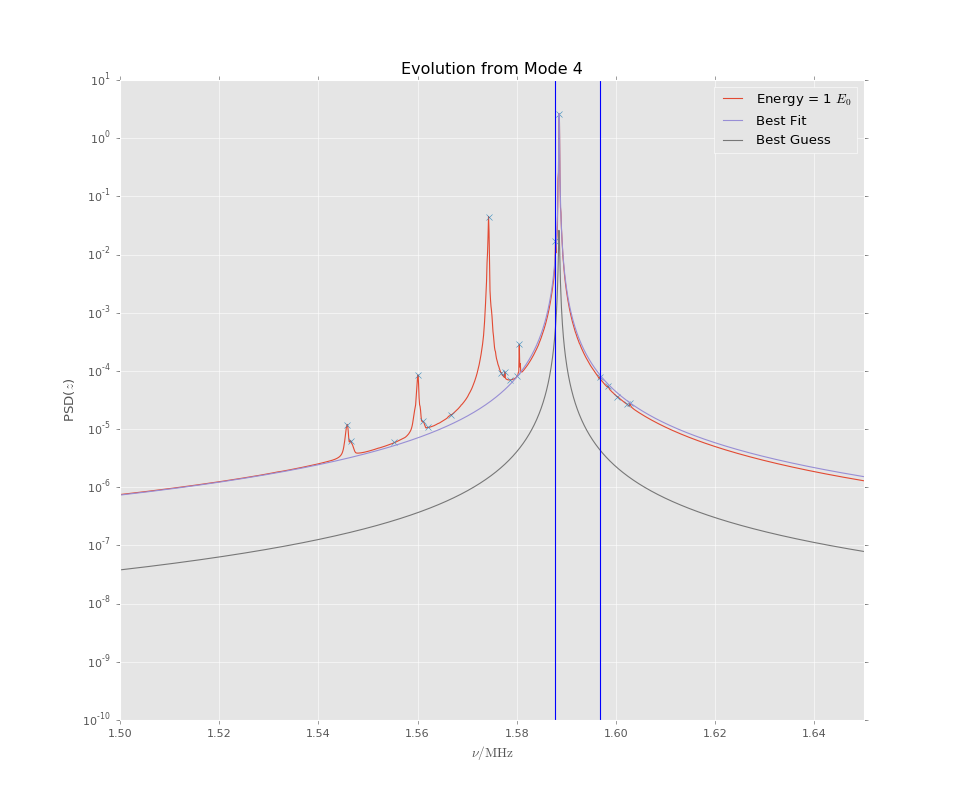

<IPython.core.display.Javascript object>


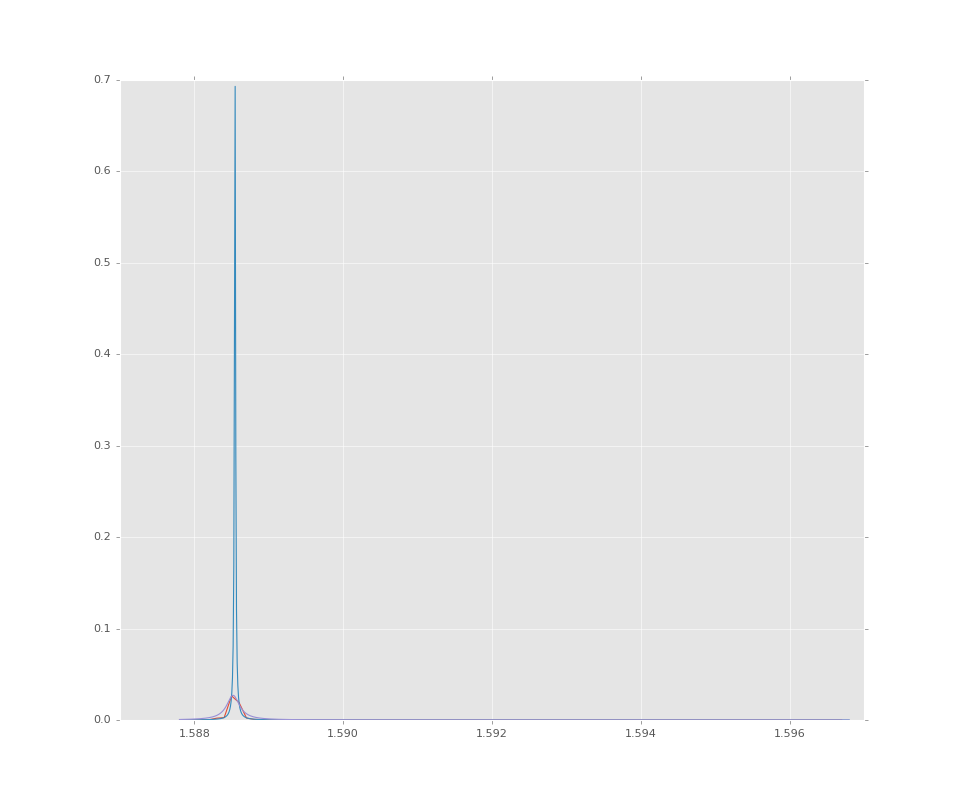

poptL = [7.24363261e+01 1.78206908e-05 1.58854585e+00]
y peak height = 2.635335788276452
x peak loc = 1588500.0


In [20]:
import scipy.signal
import scipy.optimize

def lorentzian(x, height, FWHM, x0):#, y0):
    A = np.pi * FWHM * height / 2
    L = (A / np.pi) * (0.5*FWHM/((x - x0)**2 + (0.5*FWHM)**2))
    return L

def gaussian(x, amplitude, stdDev, x0, y0):
    G = y0 + amplitude * np.exp(-(x-x0)**2/(2*stdDev**2))
    return G

data_dir = '../Data/ion-trapping-notes/tmax10e-3.dt4e-9/w1/'

x = np.load(data_dir + 'freqs.npy') # 1D numpy array
PSD_data = pd.read_pickle(data_dir + 'PSD_data') # big pandas dataframe

m = 4

mode_freq = mode_analysis.axialEvalsE[-m]/(2*np.pi) # mode frequency
ν_z = np.sqrt(2*mode_analysis.q*mode_analysis.Coeff[2]/mode_analysis.m_Be)/(2*np.pi) # trap frequency

# Make a plot!

fig, ax = plt.subplots(figsize = (12,10))

e = 1

x = x[:len(x)//2]

y = PSD_data.loc[m,e]
y = y[:len(y)//2] * 100 ##########################################

# peaks, _ = scipy.signal.find_peaks(y, distance=5)#width=1)


lorentzParams = []

# while True:


peaks, _ = scipy.signal.find_peaks(y, distance = 5)
highest = np.argmax(y[peaks])

lboundInd = np.argmin(np.absolute(x - x[highest - 1]))
rboundInd = np.argmin(np.absolute(x - x[highest + 1]))

lPeakLim = peaks[lboundInd]
rPeakLim = peaks[rboundInd]

poptL, pcovL = scipy.optimize.curve_fit(lorentzian, x/1.0e6, y, p0 = [y[peaks][highest], 210e-6, x[peaks][highest]/1.0e6])#, 0])
# poptG, pcovG = scipy.optimize.curve_fit(gaussian, x[lPeakLim:rPeakLim], y[lPeakLim:rPeakLim], p0 = [y[peaks][highest], 0.1, x[peaks][highest], 0])
# poptO, pcovO = scipy.optimize.curve_fit(other, x/1.0e6, np.log10(y), p0 = [x[peaks[highest]]/1.0e6, -10])    
#     ######START WORKING HERE:  
# #     PLOT THE CURVE FOR THE BIG PEAK BEFORE MOVING ON!  DO WE NEED TO DIVIDE HORIZONTAL DISTANCES BY 1E6
    

ax.semilogy(x/1.0e6, y, label = r'Energy = {} $E_0$'.format(e))
ax.semilogy(x[peaks]/1.0e6, y[peaks], "x")
ax.semilogy(x / 1.0e6, lorentzian(x/1.0e6, *poptL), label = "Best Fit")
ax.semilogy(x / 1.0e6, lorentzian(x/1.0e6, .027, 210e-6,1588520/1.0e6), label = "Best Guess")
# ax.semilogy(x / 1.0e6, gaussian(x/1.0e6, *poptG))

ax.axvline(x[lPeakLim]/1.0e6)
ax.axvline(x[rPeakLim]/1.0e6)

exps = np.log10(y)
mode_point = 10**(.25*exps.max() + .75*exps.min())
trap_point = 10**(.7*exps.max() + .3*exps.min())


# for i in np.arange(1,11):
#     ax.axvline(x=mode_analysis.axialEvalsE[-i]/(2*np.pi)/1.0e6, c='g')

# ax.axvline(x=mode_freq/1.0e6, c='k')

# ax.axvline(x=ν_z/1.0e6, c='b')
# ax.annotate('Mode\nFrequency', xy=(mode_freq/1.0e6, mode_point), xytext=(mode_freq/1.0e6-0.02, mode_point), 
#             arrowprops=dict(facecolor='black', shrink=0.05))
# ax.annotate(r'$\nu_z$', xy = (ν_z/1.0e6, trap_point), xytext=(1.63,trap_point),
#            arrowprops=dict(facecolor='blue', shrink=0.05))
ax.set_xlim(1.5, 1.65)#0.525 * (x[-1]/2.) / 1.0e6, 0.7 * (x[-1]/2.) / 1.0e6)
ax.set_xlabel(r'$\nu / \rm{MHz}$')
ax.set_ylabel(r'PSD($z$)')
ax.set_title(r'Evolution from Mode {}'.format(m))
ax.legend(loc='best')

fig.show()

# print(x[peaks[highest]]/1.0e6)

# fig2, ax2 = plt.subplots(figsize = (12,10))
# ax2.plot(x/1.0e6, lorentzian(x/1.0e6, *poptL))
# ax2.plot(x/1.0e6, other(x/1.0e6, poptL[2], poptL[3],5))
# fig.show()

exx = np.linspace(x[lPeakLim],x[rPeakLim],1000)
fig3, ax3 = plt.subplots(figsize = (12,10))
ax3.plot(x[lPeakLim:rPeakLim]/1.0e6,y[lPeakLim:rPeakLim]/100)
ax3.plot(exx/1.0e6, lorentzian(exx/1.0e6, *poptL)/100)
ax3.plot(exx/1.0e6, lorentzian(exx/1.0e6, .027, 210e-6,1588520/1.0e6))#*poptL))
# ax3.plot(exx, gaussian(exx, *poptG))
fig.show()

# It looks like the fitting is actually somewhat reasonable, considering the sheer amopunt of points
# on either side of the peak.  I wonder if I can get closer to expected if I shrink the x-domain of the 
# region I have curve-fit look at

# Regardless, the PSD looks pretty good, fit wise.  I think the width is the primary feature we care about.
# I should put the two curves (fit and guessed) on the PSD graph.  INCLUDE legend


print("poptL = {}".format(poptL))
print('y peak height = {}'.format(y[peaks][highest]))
print('x peak loc = {}'.format(x[peaks][highest]))

In [14]:
y[peaks][25]

2.635335788276452

<IPython.core.display.Javascript object>


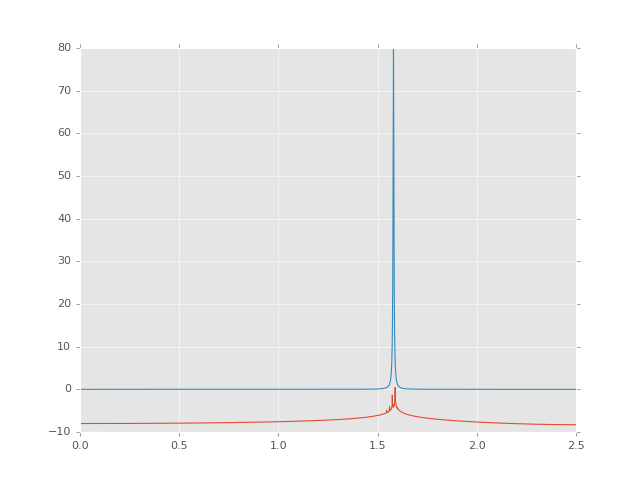

NameError: name 'other' is not defined

In [16]:
fig, ax =plt.subplots()
ax.plot(x/1.0e6, np.log10(y))
ax.plot(x/1.0e6, (lorentzian(x/1.0e6,80, 0.005, 1.58)))
ax.plot(x/1.0e6, other(x/1.0e6, 1.6,-10,.3))
ax.set_ylim(-10,2)
fig.show()
x/1e6

### <a name="consolidation"></a> Consolidation and Further Exploration

Now that we have several features that allow us to explore the behavior of various modes, we should consolidate all these features into a class that allows us to 

# TODO

* Start looking at how the energy of the eigenmode changes the frequencies
    * Put up a 'fence' of where the eigenfrequencies are and integrate the PSD to get the total power within each fence post.
    * Instead of putting up the fence, look for local maxima or peaks?  We know how many modes there are, but how do we distinguish the real peak from additive noise?
* Do some kind of error characterization of the result.  Maybe we can get error bars for our plot    
* Arghavans suggestion:  Start looking at higher order terms in the hamiltonian.  What effect do they have on the eigenmodes?
* Modify evolution:
    * Scale down energy to experimentally appropriate level
    * Select primary mode and secondary mode
    * Choose energy proportion
    * Let Evolve